<a href="https://colab.research.google.com/github/ahhCrap/Deepfake_Review_Detection/blob/master/Dataset_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-Up

In [0]:
import json
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

In [0]:
from wordcloud import WordCloud

In [0]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data_path = '/content/drive/My Drive/POLIMI/Thesis/Data/Datasets/Food/'
file_name = 'reviews_14.jsonl'
file_path = data_path + file_name
file_path

'/content/drive/My Drive/POLIMI/Thesis/Data/Datasets/Food/reviews_14.jsonl'

In [0]:
fulldata_name = 'Grocery_and_Gourmet_Food.json'
fulldata_path = data_path + fulldata_name
fulldata_path

'/content/drive/My Drive/POLIMI/Thesis/Data/Datasets/Food/Grocery_and_Gourmet_Food.json'

## Utils

In [0]:
def compute_size(dataset):
    dataset_size = 0
    with open(dataset, 'r') as f:
        for line in f:
            dataset_size += 1
    return dataset_size

In [0]:
def progress_bar(i, size, dots=10):
    if i % (size // dots) == 0:
        print('.', sep='', end='')

In [0]:
def tokenize(file_path):
    size = compute_size(file_path)
    tokenized_sentences = []
    with open(file_path, 'r') as f:
        for line in f:
            tokenized_sentences += [word_tokenize(json.loads(line)['review'].lower())]
            progress_bar(len(tokenized_sentences), size, dots=10)
    return tokenized_sentences

In [0]:
def zipf_law(k, s, n, den=None):
    if den is None:
        return (k ** -s) / (np.array(range(1, n+1)) ** -s)
    else:
        return (k ** -s) / den

In [0]:
def zipf_occ(rank, exp, max_occ):
        return max_occ * (rank ** -exp)

## Experiments:
1. Semantic difference between fake and legit reviews

  1. Word distribution difference (Zipf's law)
  2. Word use difference
  3. Semantic analysis difference
  4. PCA

In [0]:
print('metadata')
with open(fulldata_path, 'r') as f:
    for line in f:
        print(json.loads(line))
        break

metadata
{'overall': 5.0, 'verified': True, 'reviewTime': '06 4, 2013', 'reviewerID': 'ALP49FBWT4I7V', 'asin': '1888861614', 'reviewerName': 'Lori', 'reviewText': 'Very pleased with my purchase. Looks exactly like the picture and will look great on my cake. It definitely will sparkle.', 'summary': 'Love it', 'unixReviewTime': 1370304000}


In [0]:
 users = set()
 with open(fulldata_path, 'r') as f:
    for line in f:
        line = json.loads(line)
        try:
            if len(word_tokenize(line['reviewText'])) <= 14:
                users.add(line['reviewerID'])
        except:
            pass

In [0]:
len(list(users))

1178441

In [0]:
 product2review_count = {}
 with open(fulldata_path, 'r') as f:
    for line in f:
        line = json.loads(line)
        try:
            if len(word_tokenize(line['reviewText'])) <= 14:
                prod_id = line['asin']
                try:
                    product2review_count[prod_id] += 1
                except KeyError:
                    product2review_count[prod_id] = 1
        except:
            pass

In [0]:
counts = list(product2review_count.values())

In [0]:
print('average count')
sum(counts)/len(counts)

average count


10.327897325462484

In [0]:
print('min count')
print(min(counts))

print('max count')
print(max(counts))

min count
1
max count
5415


Tokenize sentences

In [0]:
tok_sents = tokenize(file_path)

..........

In [0]:
word2count = {}
for sent in tqdm(tok_sents):
    for tok in sent:
        try:
            word2count[tok] += 1
        except KeyError:
            word2count[tok] = 1

100%|██████████| 1908771/1908771 [00:03<00:00, 516577.21it/s]


In [0]:
n_words = len(word2count.keys())

In [0]:
exp = 1.07
den = sum(n ** -exp for n in range(1, n_words + 1))

rank2zipf = {rank: zipf_law(rank, exp, n_words, den=den) for rank in range(1, n_words + 1)}

In [0]:
max_occ = max(word2count.values())
rank2expected_zipf = {rank: zipf_occ(rank, exp, max_occ) for rank in range(1, n_words + 1)}

**Word Count**

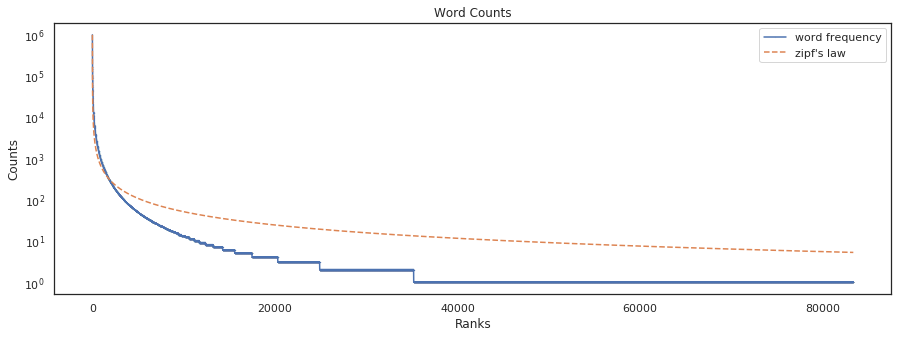

In [0]:
plt.figure(figsize=(15, 5))

plt.semilogy(sorted(word2count.values(), reverse=True), '.-', ms=0.1, label='word frequency')
plt.semilogy(sorted(rank2expected_zipf.values(), reverse=True), '--', ms=1, label="zipf's law")

plt.title('Word Counts')
plt.ylabel('Counts')
plt.xlabel('Ranks')

plt.legend()
plt.show()

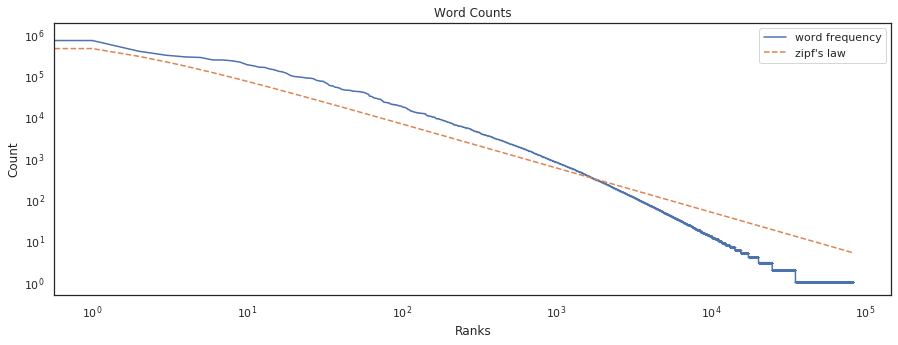

In [0]:
plt.figure(figsize=(15, 5))

plt.loglog(sorted(word2count.values(), reverse=True), '.-', ms=0.1, label='word frequency')
plt.loglog(sorted(rank2expected_zipf.values(), reverse=True), '--', ms=1, label="zipf's law")

plt.title('Word Counts')
plt.ylabel('Count')
plt.xlabel('Ranks')

plt.legend()
plt.show()

In [0]:
x = np.log(range(1, n_words + 1))
y = np.log(sorted(word2count.values(), reverse=True))

In [0]:
slope, bias = np.polyfit(x, y, deg=1)
slope, bias

(-1.5014848633832139, 16.406452826517633)

In [0]:
f = bias + slope * x

In [0]:
new_zipf = [zipf_occ(rank, -slope, max_occ) for rank in range(1, n_words + 1)]

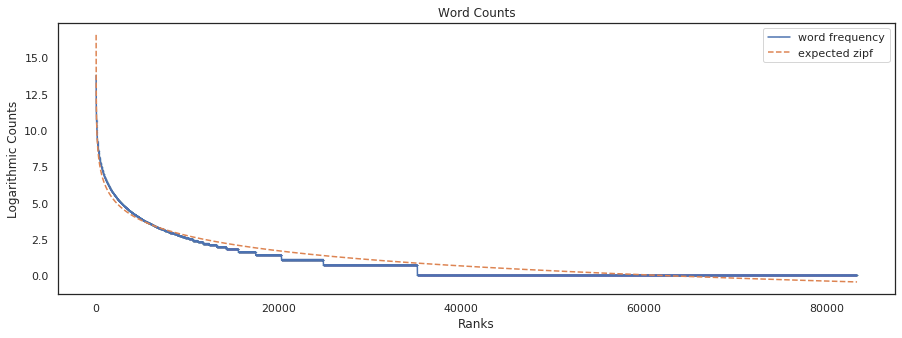

In [0]:
plt.figure(figsize=(15, 5))

plt.plot(np.exp(x), y, '.-', ms=0.1, label='word frequency')
# plt.plot(np.exp(x), f, '--', ms=1, label='straight line')
plt.plot(np.exp(x), np.log(bias) + np.log(new_zipf), '--', ms=1, label='expected zipf')

plt.title('Word Counts')
plt.ylabel('Logarithmic Counts')
plt.xlabel('Ranks')

plt.legend()
plt.show()

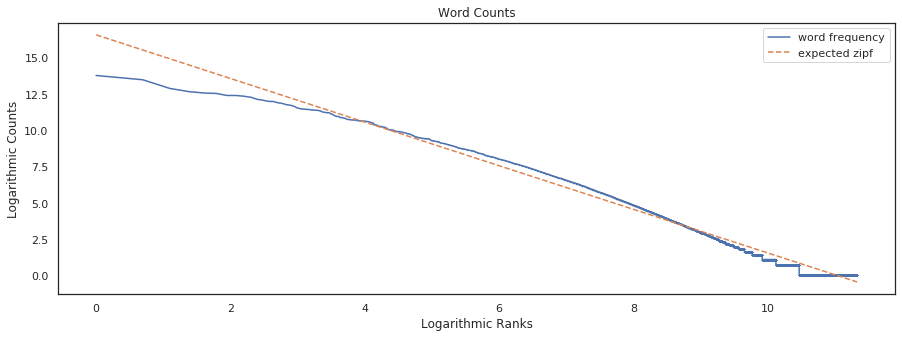

In [0]:
plt.figure(figsize=(15, 5))

plt.plot(x, y, '.-', ms=0.1, label='word frequency')
# plt.plot(x, f, '--', ms=1, label='straight line')
plt.plot(x, np.log(bias) + np.log(new_zipf), '--', ms=1, label='expected zipf')

plt.title('Word Counts')
plt.ylabel('Logarithmic Counts')
plt.xlabel('Logarithmic Ranks')

plt.legend()
plt.show()

Zipf's law doesn't really fit using the empirical exponent for the english language: $s = 1.07$

Visualizing word-occurrence.

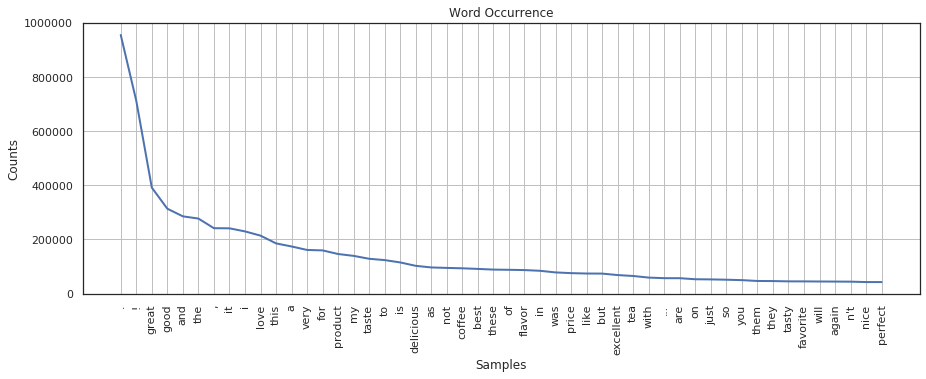

In [0]:
plt.figure(figsize=(15, 5))
plt.title('Word Occurrence')
freq_dist = nltk.FreqDist(word2count)
freq_dist.plot(50,cumulative=False)

**Sentence Length Distribution**

In [0]:
import seaborn as sns

In [0]:
lengths = [len(sent) for sent in tok_sents]

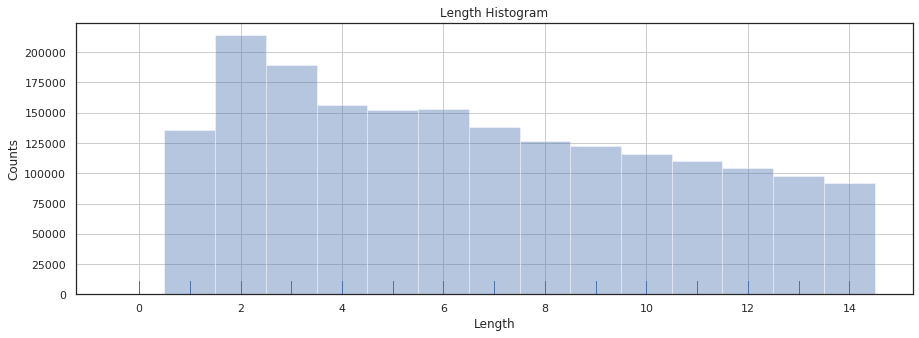

In [0]:
plt.figure(figsize=(15, 5))
sns.set_style("white")
sns.distplot(lengths, bins=np.arange(-0.5, 15.5, 1), rug=True, kde=False)

plt.title('Length Histogram')
plt.ylabel('Counts')
plt.xlabel('Length')

plt.grid()
plt.show()

**Word Cloud**

In [0]:
unwanted = set(stopwords.words('english'))
for punct in string.punctuation:
   unwanted.add(punct)

In [0]:
text = "square"
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

In [0]:
wc = WordCloud(background_color="white", mask=mask, 
               width=1000, height=1000, scale=50,
               stopwords=unwanted)
wc.generate_from_frequencies(word2count)

(0.0, 1.0, 0.0, 1.0)

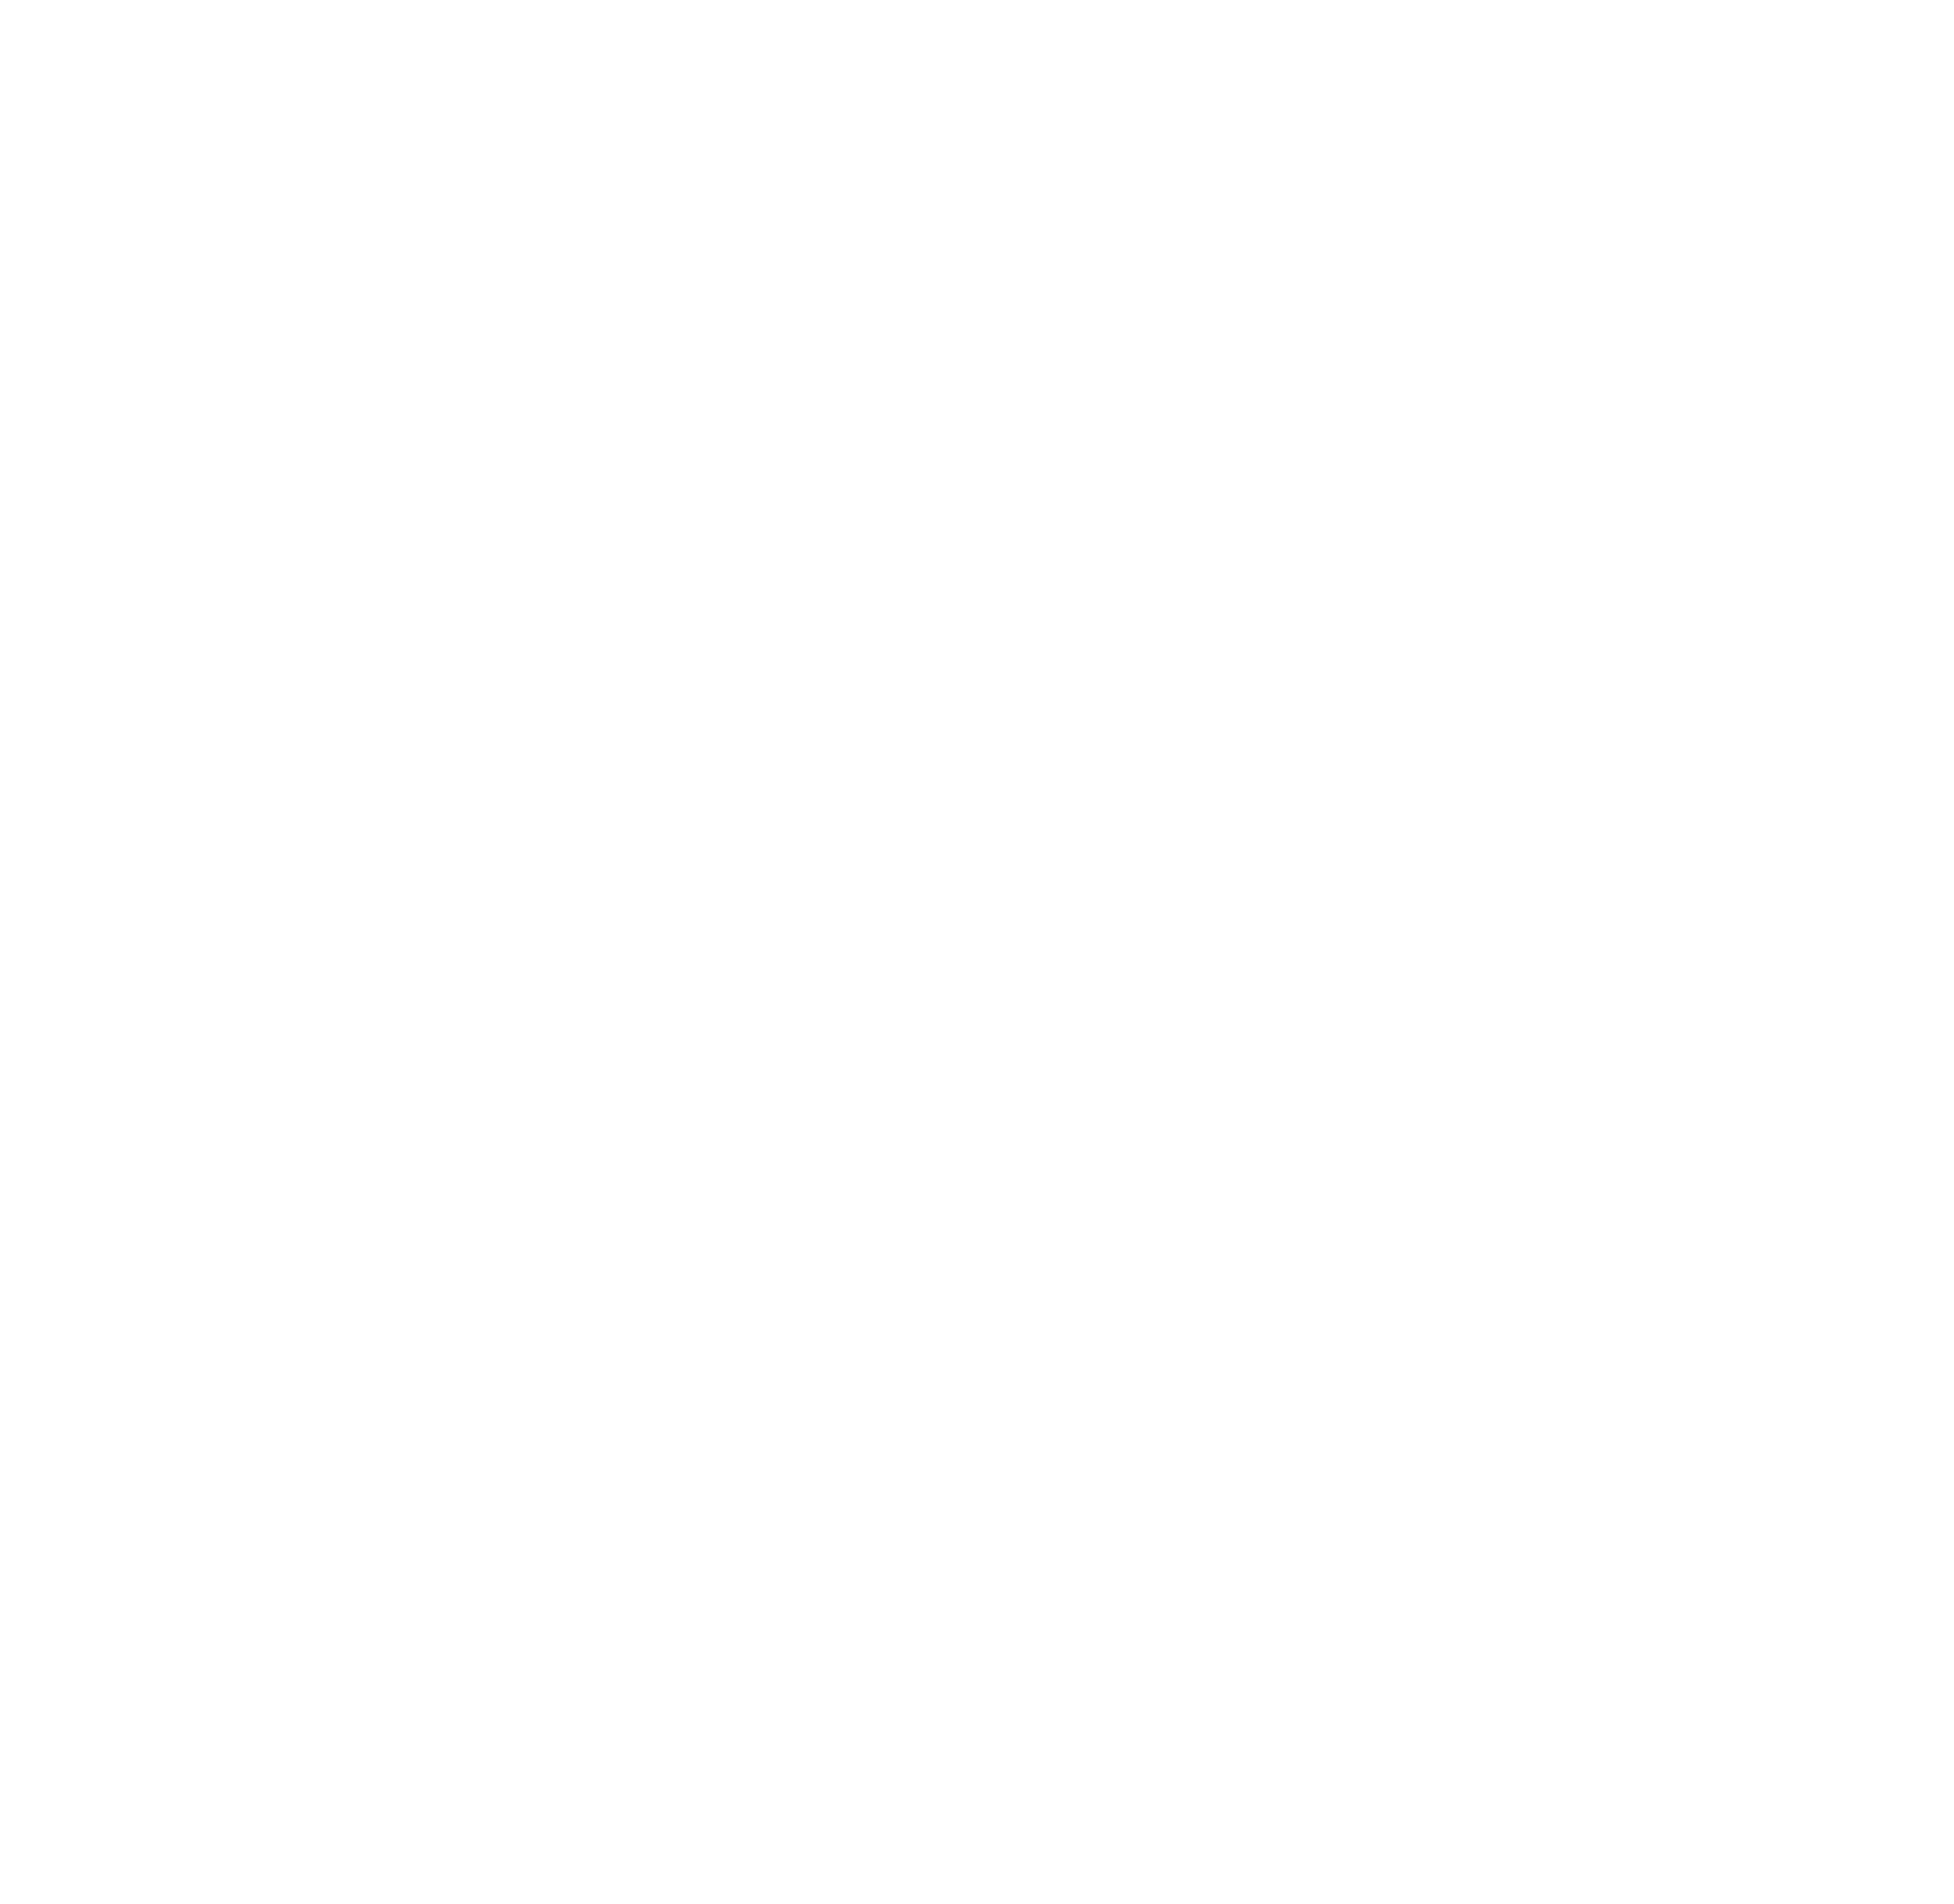

In [0]:
plt.figure(figsize=(50, 50))
plt.axis("off")
# plt.imshow(wc, interpolation="bilinear")
# plt.show()